# Text classification

**Supervised learning: classification**

**Abstract:** Classifying text, e.g. assigning a topic to a text or document, is one of the canonical examples of problems we try to solve with machine learning. This notebook demonstrates a simple example where, after training a classification algorithm with a bunch of text examples and topic labels, we use it to tell us the topic of any previously unseen text.

**Topics covevered:** multinomial naive Bayes, Bayes Theorem, feature engineering, term frequency–inverse document frequency (TF–IDF), stopwords, sparse matrices, confusion matrix.

**Motivation.** Solving such a text classification problem can be extremely useful. Say, right now your digital customer care team is swamped with comments being left on your website. You want to be able to tell the relevant comments from the irrelevant ones, and you want to know what they are about. Are they complaints about servicing times? Is a critical point in the purchase flow of the site suddenly broken? Are they about a particular aspect of a rather complex product? You want to do this classification fast and at scale. Enter machine learning.

**A word on naive Bayes.** As given away in the name, naive Bayes (NB) relies on Bayes' Theorem. Given some examples the goal is to predict the probability of a label. Say we want to decide between two labels, let's call them $L_0$ and $L_1$. For that we observe some features $(x_0, x_1, \dots, x_p) \equiv X$. In order to decide what example has what label, we can compute the ratio of the posterior probabilities 

$$
\frac{P\left(L_0 | X\right)}{P\left(L_1 | X\right)}
=
\frac{P\left(X | L_0\right)P\left(L_0\right)}{P\left(X | L_1\right)P\left(L_1\right)}
.
$$

This provides us with a measure of the uncertainty attached to every label-assignment decision we make.

The group of NB classification models are _generative_, meaning they try to specify the (hypothetical) distribution of each underlying class. The 'naive' part comes from the fact that we make very loose assumptions about the process that generated the data. Multinomial NB for one, assumes the data we observe was generated from a simple, run-of-the-mill multinomial distribution. NB algorithms are simple, fast and very effective when working with high-dimensional data.

**Setup & data.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
%matplotlib inline

[nltk_data] Downloading package stopwords to /Users/dnl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Fetch data
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups()
# Load training and test sets
train = fetch_20newsgroups(subset='train', categories=data.target_names)
test = fetch_20newsgroups(subset='test', categories=data.target_names)

In this notebook we use the '20 newsgroups' dataset from `sklearn`. The data comprises around 18,000 newsgroups posts on 20 topics ranging from computer graphics, motorcycles to gun politics and religion.

In [3]:
print('Number of topics:', len(data.target_names))
# Display labels
data.target_names

Number of topics: 20


['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Let's look at some excerpts:

In [4]:
print('Topic:', train.target_names[train.target[-1]], 
      '\n', '     ', '-'*len(train.target_names[train.target[-1]]), '\n')
print(train.data[-1])
print('='*40, '\n')
print('Topic:', train.target_names[train.target[-5]], 
      '\n', '     ', '-'*len(train.target_names[train.target[-5]]), '\n')
print(train.data[-5])

Topic: rec.motorcycles 
       --------------- 

From: gunning@cco.caltech.edu (Kevin J. Gunning)
Subject: stolen CBR900RR
Organization: California Institute of Technology, Pasadena
Lines: 12
Distribution: usa
NNTP-Posting-Host: alumni.caltech.edu
Summary: see above

Stolen from Pasadena between 4:30 and 6:30 pm on 4/15.

Blue and white Honda CBR900RR california plate KG CBR.   Serial number
JH2SC281XPM100187, engine number 2101240.

No turn signals or mirrors, lights taped over for track riders session
at Willow Springs tomorrow.  Guess I'll miss it.  :-(((

Help me find my baby!!!

kjg



Topic: sci.med 
       ------- 

From: jim.zisfein@factory.com (Jim Zisfein) 
Subject: Re: Migraines and scans
Distribution: world
Organization: Invention Factory's BBS - New York City, NY - 212-274-8298v.32bis
Reply-To: jim.zisfein@factory.com (Jim Zisfein) 
Lines: 37

DN> From: nyeda@cnsvax.uwec.edu (David Nye)
DN> A neurology
DN> consultation is cheaper than a scan.

And also better, because a ne

**Feature engineering.** Before we can have the computer work with the data we need to convert the text in the posts into a numerical representation. This process is known as feature engineering. We take whatever information we have and turn it into numbers; often a real-valued vector or matrix. This way we extract the relevant features so we can feed them to our algorithm. 

A good starting point for converting text into a set of representative numerical values would be, for instance, to simply count the frequency of each word in the text. This would leave us with a matrix where each row represents a post and each column represents a word. The matrix entries represent the word counts. So each time a word appears in a post we add one to the respective row and column. As you can imagine, most of the entries in this matrix would be 0 or 'empty', for that reason it is not a dense matrix but a sparse one.

A simple example should develop our intuition. Let's assume we have the following three posts. We can quickly visualize the resulting sparse matrix of the word counts with off-the-shelf tools.

In [5]:
samples = ['you have to peel the onion',
           'one day I am going to make an onion cry',
           'an onion a day keeps everyone away']

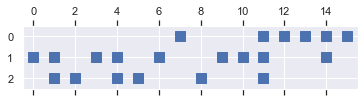

In [6]:
# Compute sparse matrix with raw counts
v = CountVectorizer()
S = v.fit_transform(samples)
# Viz
plt.spy(S)

In [7]:
# Or as a table
tab = pd.DataFrame(S.toarray(), columns=v.get_feature_names())
pd.options.display.float_format = "{:,.1f}".format
display(tab)

,am,an,away,cry,day,everyone,going,have,keeps,make,one,onion,peel,the,to,you
0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,1
1,1,1,0,1,1,0,1,0,0,1,1,1,0,0,1,0
2,0,1,1,0,1,1,0,0,1,0,0,1,0,0,0,0


Already we can see that there are some issues with this approach. For one, we count all words irrespective of how meaningful they are. For another, we assign weight to words only by their raw count. Take 'am', 'an', 'one' or 'to' for instance. These appear equally frequently or even more frequently than actual keywords. So by keeping these 'useless' words on and giving them equal or more weight than to actual useful words we end up with a lot of meaningless features in our data. And this only makes finding interesting patterns harder.

**A quick fix.** We can easily tackle both of these issues, though. First, we can remove those words that occur frequently but do not carry substantive meaning. These are known as _stopwords_. Removing stopwords is a common text-preprocessing step. We can get a comprehensive list of stopwords from the `nltk` module.

In [8]:
# Load English stopwords
stpw = stopwords.words('english')
# Display a few
print(stpw[-10:])

['shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]


Second, we can calibrate the weights by how often words appear in all posts. This approach is known as term frequency–inverse document frequency (TF–IDF). The function `TfidfVectorizer` from `sklearn` has a built-in parameter that let's us parse stopwords as a list of strings.

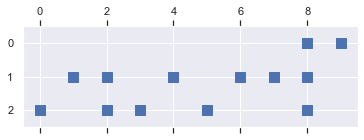

In [9]:
# Compute sparse matrix with raw counts
v = TfidfVectorizer(stop_words=stpw)
S = v.fit_transform(samples)
# Viz
plt.spy(S)

In [10]:
tab = pd.DataFrame(S.toarray(), columns=v.get_feature_names())
keywords = list(({w for w in tab.columns if w not in stpw}))
pd.options.display.float_format = "{:,.1f}".format
display(tab[keywords])

,onion,cry,make,one,peel,keeps,day,away,everyone,going
0,0.5,0.0,0.0,0.0,0.9,0.0,0.0,0.0,0.0,0.0
1,0.3,0.5,0.5,0.5,0.0,0.0,0.3,0.0,0.0,0.5
2,0.3,0.0,0.0,0.0,0.0,0.5,0.4,0.5,0.5,0.0


This sparse matrix is now a good numerical representation of the important words in our posts. We will use it to train our multinomial NB algorithm.

**Train model & make prediction on test set.**

In [11]:
# Build model
mnb = make_pipeline(TfidfVectorizer(stop_words=stpw), 
                    MultinomialNB())

In [12]:
# Train with training set
mnb.fit(train.data, train.target)
# Predict on test set
labels = mnb.predict(test.data)

As we can see at this point, a huge advantage of using a 'naive' model is that we don't need to bother with choosing and fine-tuning hyperparameters. So no need to do any cross-validation, grid searches or the likes. Let's see how well the multinomial NB model does in correctly telling the topic of a previously unseen text. For that we'll construct a confusion matrix.

**Confusion matrix.**

Text(0.5, 1.0, 'Confusion Matrix')

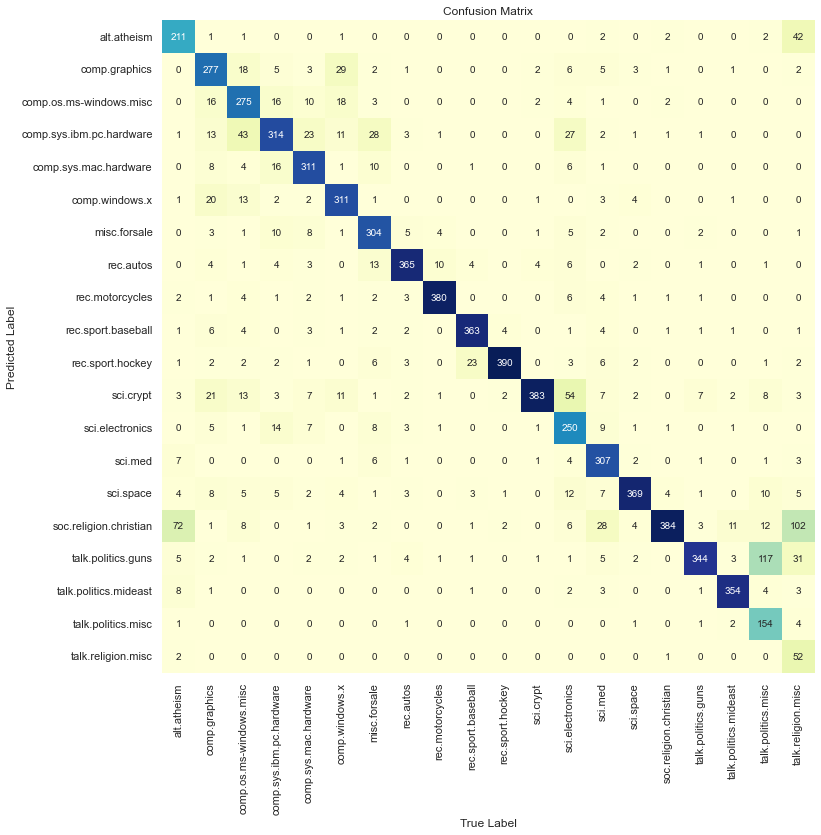

In [13]:
# Compute CM
cm = confusion_matrix(test.target, labels)
# Plot
plt.subplots(figsize=(12, 12))
sns.heatmap(cm.T, square=True, annot=True, cmap='YlGnBu', fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Confusion Matrix')

In [14]:
# Compute accuracy score
print('Overall accuracy of multinomial NB model: {:2.2%}'.format(accuracy_score(test.target, labels)))

Overall accuracy of multinomial NB model: 80.96%


We see that a naive algorithm such as this does very well in telling the topic of new posts. 81% of the time it will be correct! It does seem, however, to have a hard time separating atheist posts from christian ones, or general politics from gun chatter. It also confuses religious text with Christian and atheist texts. These confusions stem from the fact that many words appear with similar frequency in these topics so that the computer cannot really tell them apart.

**What now?** The cool thing now that we have a pretty accurate predictive model to classify text, is that we get to play around with it! :) 

In an image classification setting it would be more cumbersome to provide the model with new images that are outside the test set. But with text classification, well, we can always write something semi-coherent with a topic in mind and see if the trained algorithm guesses it. And if you can't come up with anything yourself, well, there's always Google.

Let's first create a helper function to ease things along. Then some obvious examples below. If you are running this notebook live, you can type in whatever comes to your mind.

In [15]:
def guess_topic(s):
    probs = mnb.predict_proba([s])[0]
    top3 = np.argsort(probs)[:-4:-1]
    r_0 = '1st guess is {} with {:2.2%} certainty.'.format(train.target_names[top3[0]], 
                                                            probs[top3[0]])
    r_1 = '2nd guess is {} with {:2.2%} certainty.'.format(train.target_names[top3[1]], 
                                                            probs[top3[1]])
    r_2 = '3rd guess is {} with {:2.2%} certainty.'.format(train.target_names[top3[2]], 
                                                            probs[top3[2]])
    print(r_0 + '\n' + r_1 + '\n' + r_2)

In [16]:
guess_topic('I think my screen is broken. The resolution is all off.')

1st guess is comp.os.ms-windows.misc with 11.04% certainty.
2nd guess is comp.sys.mac.hardware with 10.36% certainty.
3rd guess is comp.graphics with 9.33% certainty.


In [17]:
guess_topic('Is you Harley just outside? Can we go for a ride?')

1st guess is rec.motorcycles with 40.91% certainty.
2nd guess is rec.autos with 4.81% certainty.
3rd guess is talk.politics.guns with 4.40% certainty.


In [18]:
guess_topic('American Epidemic: One Nation Under Fire')

1st guess is talk.politics.guns with 16.89% certainty.
2nd guess is talk.politics.mideast with 10.62% certainty.
3rd guess is talk.politics.misc with 7.38% certainty.


In [19]:
guess_topic('The Perseid meteor shower is often considered one of the best meteor showers of the year.')

1st guess is rec.sport.baseball with 8.33% certainty.
2nd guess is rec.sport.hockey with 6.38% certainty.
3rd guess is sci.med with 6.21% certainty.


The first three guesses were spot on! The last one not so much. But alas, the algorithm is correct 81% of the time. It's bound not to get all guesses right.